<a href="https://colab.research.google.com/github/PTrillat/Reinforcement-Learning/blob/main/Pendule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Le simulateur du pendule inversé
Équations de Lagrange + RK4 pour l'intégration numérique

In [143]:
import torch
import random
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from itertools import count
from collections import namedtuple, deque

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Pendule(object):
  """
  On travail avec des grandeurs adimensionnées pour généraliser l'apprentissage
  Grandeures de référence:
   - m (masse du pendule)       [m] = kg
   - l (longueur du pendule)    [l] = m
   - T (durée de la simulation) [T] = s
  Grandeures standardisées:
   - g (accélération de gravité) remplacé par gT²/l   nomé g
   - C (couple du moteur)        remplacé par CT²/ml² nomé C
   - dt (pas de temps)           remplacé par dt/T    nomé dh
   - dθ/dt (rotation)            remplacé par dθ/dh   nomé dX
  """
  def __init__(self, dh, g, θ, dθ_dh):
    self.const = (dh, g)
    self.X0 = np.array([θ, dθ_dh])
    self.X = np.copy(self.X0)
  
  def zero(self):
    self.X = np.copy(self.X0)
  
  @staticmethod
  def Variation(dh, g, θ, dθ_dh, C):
    return (np.cos(θ)-0.1*C*dθ_dh)*dh, np.array([dθ_dh*dh, (g*np.sin(θ) + C)*dh*dh])
  
  def Simpson(self, C=0.0):
    X0 = self.X
    r0, dX0 = self.Variation(*self.const, *X0, C)
    X1 = X0 + dX0/2
    r1, dX1 = self.Variation(*self.const, *X1, C)
    X2 = X0 + dX1/2
    r2, dX2 = self.Variation(*self.const, *X2, C)
    X3 = X0 + dX2
    r3, dX3 = self.Variation(*self.const, *X3, C)
    self.X += (dX0 + 2*dX1 + 2*dX2 + dX3)/6
    return (r0 + 2*r1 + 2*r2 + r3)/6


"""class Chariot(object):
  On travail avec des grandeurs adimensionnées pour généraliser l'apprentissage
  Grandeures de référence:
   - m (masse du pendule)       [m] = kg
   - l (longueur du pendule)    [l] = m
   - T (durée de la simulation) [T] = s
  Grandeures standardisées:
   - g (accélération de gravité) remplacé par gT²/l   nomé g
   - F (force du moteur)         remplacé par FT²/ml  nomé F
   - t (temps)                   remplacé par t/T     nomé h
   - M (masse du chariot)        remplacé par M/m     nomé µ
   - x (position)                remplacé par x/l     nomé x
   - dθ/dt (rotation)            remplacé par dθ/dh   nomé dθ
  def __init__(self, dh, µ, g, x, θ, dx, dθ):
    self.const = (dh, µ, g)
    self.r  = 0.0
    self.X  = np.array([x, θ])
    self.dX = np.array([dx, dθ])
  
  @staticmethod
  def Variation(dh, µ, g, x, θ, dx, dθ, F):
    s, c = np.sin(θ), np.cos(θ)
    A, B = F*dh*dh + s*dθ*dθ, g*s*dh*dh
    return np.cos(θ)*dh-0.9*F*dx, np.array([A - c*B, c*A + (µ+1)*B])/(µ+s*s)

  def Simpson(self, F=0.0):
    X0 = self.X
    dX0 = self.dX
    dJ0, ddX0 = self.Variation(*self.const, *X0, *dX0, F)
    X1 = X0 + dX0/2
    dX1 = dX0 + ddX0/2
    dJ1, ddX1 = self.Variation(*self.const, *X1, *dX1, F)
    X2 = X0 + dX1/2
    dX2 = dX0 + ddX1/2
    dJ2, ddX2 = self.Variation(*self.const, *X2, *dX2, F)
    X3 = X0 + dX2
    dX3 = dX0 + dX2
    dJ3, ddX3 = self.Variation(*self.const, *X3, *dX3, F)
    self.r   = ( dJ0 + 2* dJ1 + 2* dJ2 +  dJ3)/6
    self.X  += ( dX0 + 2* dX1 + 2* dX2 +  dX3)/6
    self.dX += (ddX0 + 2*ddX1 + 2*ddX2 + ddX3)/6"""

"class Chariot(object):\n  On travail avec des grandeurs adimensionnées pour généraliser l'apprentissage\n  Grandeures de référence:\n   - m (masse du pendule)       [m] = kg\n   - l (longueur du pendule)    [l] = m\n   - T (durée de la simulation) [T] = s\n  Grandeures standardisées:\n   - g (accélération de gravité) remplacé par gT²/l   nomé g\n   - F (force du moteur)         remplacé par FT²/ml  nomé F\n   - t (temps)                   remplacé par t/T     nomé h\n   - M (masse du chariot)        remplacé par M/m     nomé µ\n   - x (position)                remplacé par x/l     nomé x\n   - dθ/dt (rotation)            remplacé par dθ/dh   nomé dθ\n  def __init__(self, dh, µ, g, x, θ, dx, dθ):\n    self.const = (dh, µ, g)\n    self.r  = 0.0\n    self.X  = np.array([x, θ])\n    self.dX = np.array([dx, dθ])\n  \n  @staticmethod\n  def Variation(dh, µ, g, x, θ, dx, dθ, F):\n    s, c = np.sin(θ), np.cos(θ)\n    A, B = F*dh*dh + s*dθ*dθ, g*s*dh*dh\n    return np.cos(θ)*dh-0.9*F*dx, np.ar

Animation du pendule et du chariot pour vérifier

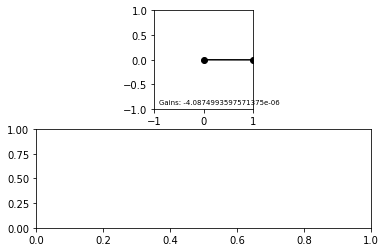

In [144]:
# Paramètres pour l'animation
T, f, l = 5.0, 20, 0.1 # s, Hz = 1/dt, m

dh = 1.0/(f*T)
pendule = Pendule(dh,      9.81*T*T/l,      np.pi/2,      0.0)
#chariot = Chariot(dh, 1.0, 9.81*T*T/l, 0.0, -np.pi/2, 0.0, 0.0)

fig, (axe_pendule, axe_chariot) = plt.subplots(2,1)

axe_pendule.set_xlim(-1,1)
axe_pendule.set_ylim(-1,1)
axe_pendule.set_aspect('equal', 'box')
barre_pendule, = axe_pendule.plot([], [], 'ko-')
texte_pendule  = axe_pendule.text(-0.9, -0.9, '', fontsize=7)

"""axe_chariot.set_xlim(-1,1)
axe_chariot.set_ylim(-1,1)
axe_chariot.set_aspect('equal', 'box')
barre_chariot, = axe_chariot.plot([], [], 'ko-')
texte_chariot  = axe_chariot.text(-0.9, -0.9, '', fontsize=7)"""

def animate(i):
  r = pendule.Simpson(0.0)
  θ, dθ = pendule.X
  barre_pendule.set_data([0, np.sin(θ)], [0, np.cos(θ)])
  texte_pendule.set_text('Gains: '+str(r))
  """dx, dθ = chariot.dX
  chariot.Simpson(0.0)
  x, θ = chariot.X
  barre_chariot.set_data([x, x+np.sin(θ)], [0, np.cos(θ)])
  texte_chariot.set_text('Gains: '+str(chariot.J))"""
  return barre_pendule, #barre_chariot
 
ani = animation.FuncAnimation(fig, animate, frames=int(f*T), blit=True, interval=int(1000/f), repeat=False)

Et on lance l'animation

In [145]:
from matplotlib import rc
rc('animation', html='html5')

ani

CalledProcessError: ignored

# Les réseaux de neurones

In [146]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
torch.autograd.set_detect_anomaly(True)

class Doublet(nn.Module):
  def __init__(self, long_s, interm, long_a):
    super(Doublet, self).__init__()
    # π(s) = a
    self.pi1 = nn.Linear(long_s, interm)
    self.pi2 = nn.Linear(interm, long_a)
    # Q(s,a) = P (ῥῶ majuscule) = R chapeau = estimé de R(s,a)
    self.qu1 = nn.Linear(long_s+long_a, interm)
    self.qu2 = nn.Linear(interm, 1)
  
  def forward(self, s):
    temp = F.relu(self.pi1(s))
    a = F.relu(self.pi2(temp))
    temp = F.relu(self.qu1(torch.cat((s,a), dim=-1)))
    P = F.relu(self.qu2(temp))
    return a, P

# L'agent

In [153]:
class Agent_Pendule(object):
  def __init__(self, T, f, l):
    dh = 1.0/(f*T)
    self.pendule = Pendule(dh, 9.81*T*T/l, -np.pi, 0.0)
    self.doublet = Doublet(2, 5, 1)
    self.optimiser = optim.Adam(self.doublet.parameters(), lr=3e-2)
    self.N = int(f*T)
  
  @staticmethod
  def calculR(r, gamma=0.99):
    R = []
    Rt = 0.0
    for rt in r[::-1]:
      Rt = gamma*Rt + rt
      R.append(Rt)
    return R[::-1]
  
  def main(self):
    for episode in range(50):
      self.pendule.zero()
      self.optimiser.zero_grad()
      for t in range(10):
        st = torch.from_numpy(self.pendule.X).float()
        at, Pt = self.doublet(st)
        rt = self.pendule.Simpson(at.detach().numpy())
        erreur = F.smooth_l1_loss(Pt, torch.tensor([rt], dtype=torch.float, requires_grad=False)) # pas du RL mais on essaye
        erreur.backward()
      self.optimiser.step()

In [154]:
agent = Agent_Pendule(1.0, 20.0, 0.1)
agent.main()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


TypeError: ignored

In [ ]:
agent.pi.requires_grad_